In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # The new library

# --- Step 1: Get the Data ---

# Define the tickers for our pair
ticker1 = 'HDFCBANK.NS'
ticker2 = 'ICICIBANK.NS'

# Define the time period (5 years is good for this)
start_date = '2019-01-01'
end_date = '2023-12-31'

print(f"Fetching data for {ticker1} and {ticker2}...")

# Download the 'Close' price data for both tickers
data = yf.download([ticker1, ticker2], start=start_date, end=end_date)['Close']

# Rename columns for easier access
data.columns = ['HDFC', 'ICICI']

# Drop any rows with missing data (just in case)
data = data.dropna()
data = data[~data.index.duplicated(keep='first')]

print("Data fetched successfully:")
print(data.head()) # Show the first 5 rows

Fetching data for HDFCBANK.NS and ICICIBANK.NS...


/var/folders/dr/1yrd_yts04zc5b6grgklwnl40000gn/T/ipykernel_21323/3121790527.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([ticker1, ticker2], start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed

Data fetched successfully:
                  HDFC       ICICI
Date                              
2019-01-01  504.392487  350.957031
2019-01-02  499.790222  351.777130
2019-01-03  495.868958  350.474609
2019-01-04  497.195587  352.356049
2019-01-07  497.946991  354.768127


Calculating hedge ratio...
Calculated Hedge Ratio (Beta): 0.4645
Spread calculated.
Plotting the spread over time...


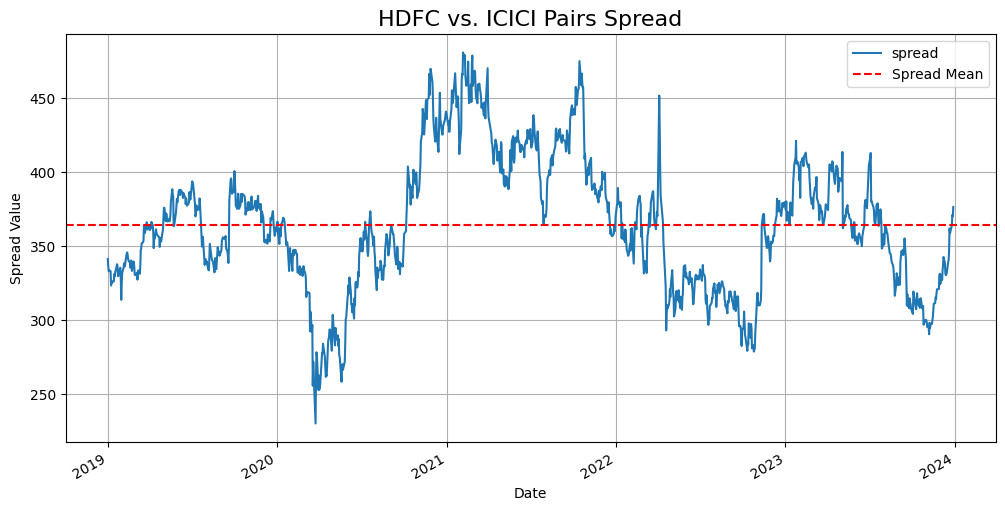

In [2]:
# --- Step 2: Find the Hedge Ratio and Calculate the Spread ---

print("Calculating hedge ratio...")

# We need to find the relationship: HDFC = beta * ICICI + c
# 'y' is the dependent variable (HDFC)
y = data['HDFC']

# 'x' is the independent variable (ICICI)
# We use sm.add_constant(x) to add an intercept (the 'c' term)
x = sm.add_constant(data['ICICI'])

# Run the Ordinary Least Squares (OLS) regression
model = sm.OLS(y, x).fit()

# The hedge ratio is the 'beta' coefficient from the regression
# It's the parameter associated with our 'x' (ICICI)
hedge_ratio = model.params['ICICI']

print(f"Calculated Hedge Ratio (Beta): {hedge_ratio:.4f}")

# Now, create the spread: Spread = HDFC - (hedge_ratio * ICICI)
data['spread'] = data['HDFC'] - hedge_ratio * data['ICICI']

print("Spread calculated.")

# --- Plot the Spread ---
print("Plotting the spread over time...")

plt.figure(figsize=(12, 6))
data['spread'].plot()
plt.axhline(data['spread'].mean(), color='red', linestyle='--', label='Spread Mean')
plt.title("HDFC vs. ICICI Pairs Spread", fontsize=16)
plt.ylabel("Spread Value")
plt.legend()
plt.grid(True)
plt.show()

Calculating Z-Score and generating signals...
Signals generated.
Plotting Z-Score with entry/exit thresholds...


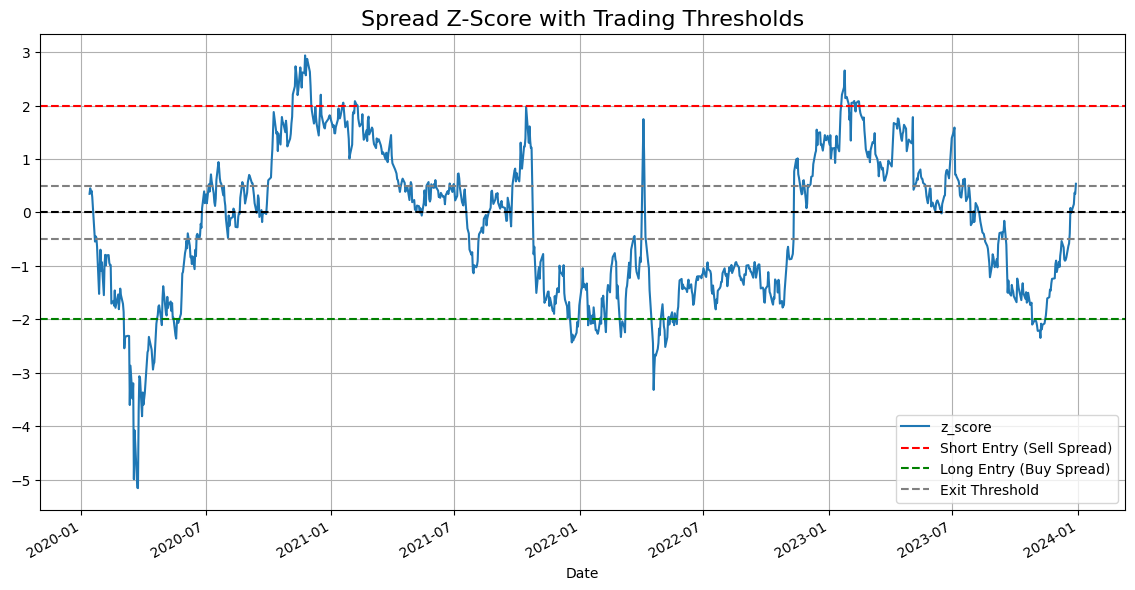

In [3]:
# --- Step 3: Generate Trading Signals Using Z-Score ---

print("Calculating Z-Score and generating signals...")

# Calculate the 1-year (252-day) rolling Z-Score of the spread
# This is more robust than using a static mean and std
rolling_mean = data['spread'].rolling(window=252).mean()
rolling_std = data['spread'].rolling(window=252).std()

data['z_score'] = (data['spread'] - rolling_mean) / rolling_std

# Define our entry/exit thresholds
# We'll trade when the spread is 2 standard deviations away
entry_threshold = 2.0
exit_threshold = 0.5 # We'll exit when it gets back close to the mean

# Create signals
# -1 = Short the spread (Sell HDFC, Buy ICICI)
#  1 = Long the spread (Buy HDFC, Sell ICICI)
#  0 = No position
data['signal'] = 0

# Go LONG the spread (Buy HDFC, Sell ICICI) when Z-Score is very low
data.loc[data['z_score'] < -entry_threshold, 'signal'] = 1

# Go SHORT the spread (Sell HDFC, Buy ICICI) when Z-Score is very high
data.loc[data['z_score'] > entry_threshold, 'signal'] = -1

# Exit positions when Z-Score is back near the mean
data.loc[(data['z_score'].abs() < exit_threshold), 'signal'] = 0

# 'fill_forward' our signals. 
# Once we're in a position, we stay in it until an exit signal.
data['position'] = data['signal'].replace(0, np.nan).ffill().fillna(0)

print("Signals generated.")

# --- Plot the Z-Score and signals ---
print("Plotting Z-Score with entry/exit thresholds...")

plt.figure(figsize=(14, 7))
data['z_score'].plot()

plt.axhline(0, color='black', linestyle='--')
plt.axhline(entry_threshold, color='red', linestyle='--', label='Short Entry (Sell Spread)')
plt.axhline(-entry_threshold, color='green', linestyle='--', label='Long Entry (Buy Spread)')
plt.axhline(exit_threshold, color='gray', linestyle='--', label='Exit Threshold')
plt.axhline(-exit_threshold, color='gray', linestyle='--')

plt.title("Spread Z-Score with Trading Thresholds", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

/var/folders/dr/1yrd_yts04zc5b6grgklwnl40000gn/T/ipykernel_21323/945275808.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_df = yf.download('^NSEI', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Backtesting the strategy...
Analyzing performance...

--- PAIRS TRADING BACKTEST RESULTS ---
Period: 2019-01-01 to 2023-12-31

----- NIFTY 50 (BENCHMARK) -----
Total Return: 101.36%
Sharpe Ratio: 0.85

----- PAIRS TRADING STRATEGY -----
Total Return: 35.19%
Annual Volatility: 9.41%
Sharpe Ratio: 0.70
Correlation to NIFTY: 0.22
--------------------------------------

Generating final P&L plot...


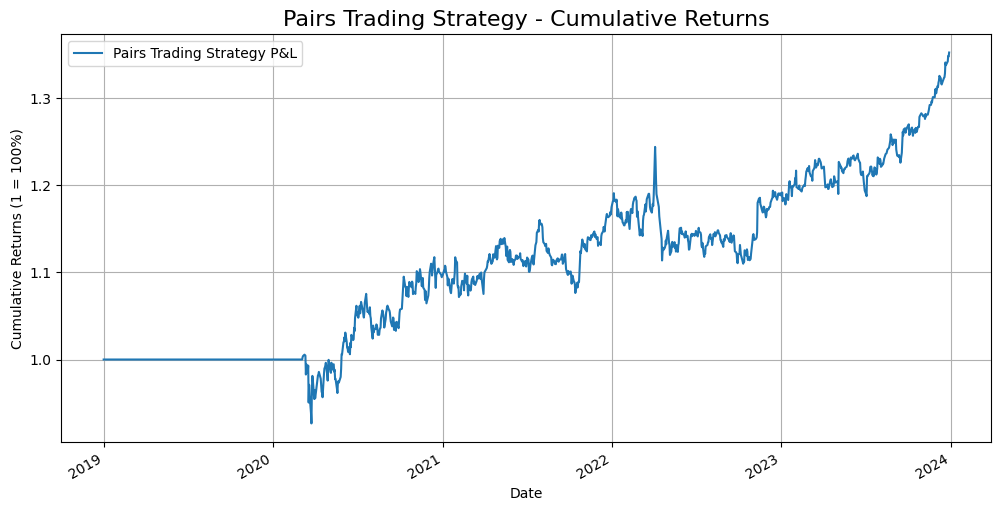

In [6]:
# --- Step 4: Backtest the Strategy and Calculate P&L ---

print("Backtesting the strategy...")

# Calculate daily returns for each stock
data['HDFC_returns'] = data['HDFC'].pct_change().fillna(0)
data['ICICI_returns'] = data['ICICI'].pct_change().fillna(0)

# Calculate the strategy's returns
# We need to .shift(1) on our position to avoid look-ahead bias!
position = data['position'].shift(1).fillna(0)

# When position is 1 (Long Spread): We are long HDFC (+1) and short ICICI (-hedge_ratio)
# When position is -1 (Short Spread): We are short HDFC (-1) and long ICICI (+hedge_ratio)
data['strategy_returns'] = (
    (position * data['HDFC_returns']) + 
    (position * -hedge_ratio * data['ICICI_returns'])
) / 2 # Assuming 50/50 capital split on the 2 legs

# Calculate Cumulative P&L
data['strategy_cumulative'] = (1 + data['strategy_returns']).cumprod()

# --- Step 5: Analyze the Results ---

print("Analyzing performance...")

# --- Also calculate a simple NIFTY benchmark ---
nifty_df = yf.download('^NSEI', start=start_date, end=end_date)
nifty_df = nifty_df[~nifty_df.index.duplicated(keep='first')]

# 1. Calculate returns.
nifty_returns_data = nifty_df['Close'].pct_change().fillna(0)

# 2. Create the benchmark DataFrame (df_nifty)
if isinstance(nifty_returns_data, pd.Series):
    # This is the expected behavior
    nifty_returns_data.name = 'nifty_returns'
    df_nifty = nifty_returns_data.to_frame()
else:
    # This is the workaround for your environment
    # We assume it's already a DataFrame and just rename its column
    df_nifty = nifty_returns_data
    df_nifty.columns = ['nifty_returns']

# 4. Create the strategy DataFrame
df_strategy = data[['strategy_returns']]

# 5. Merge
merged_data = pd.merge(df_strategy, df_nifty, left_index=True, right_index=True, how='inner').fillna(0)

# 6. Calculate correlation
correlation = merged_data['strategy_returns'].corr(merged_data['nifty_returns'])

# --- Get the other metrics ---
# THIS LINE IS NOW CORRECTED (no extra .iloc[-1])
total_return_strat = (data['strategy_cumulative'].iloc[-1] - 1) * 100
volatility_strat = data['strategy_returns'].std() * np.sqrt(252) * 100
sharpe_ratio_strat = (data['strategy_returns'].mean() * 252) / (data['strategy_returns'].std() * np.sqrt(252))

# --- THIS IS THE FIX ---
# We must use the 'nifty_returns' column from the df_nifty DataFrame
total_return_bench = ((1 + df_nifty['nifty_returns']).cumprod().iloc[-1] - 1) * 100
sharpe_ratio_bench = (df_nifty['nifty_returns'].mean() * 252) / (df_nifty['nifty_returns'].std() * np.sqrt(252))


# --- Print the Final Report ---
print("\n--- PAIRS TRADING BACKTEST RESULTS ---")
print(f"Period: {start_date} to {end_date}")

print("\n----- NIFTY 50 (BENCHMARK) -----")
print(f"Total Return: {total_return_bench:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_bench:.2f}")

print("\n----- PAIRS TRADING STRATEGY -----")
print(f"Total Return: {total_return_strat:.2f}%")
print(f"Annual Volatility: {volatility_strat:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_strat:.2f}")
print(f"Correlation to NIFTY: {correlation:.2f}") # This is the "wow" number
print("--------------------------------------\n")


# --- Plot the Final P&L Curve ---
print("Generating final P&L plot...")
plt.figure(figsize=(12, 6))
data['strategy_cumulative'].plot(label='Pairs Trading Strategy P&L')
plt.title('Pairs Trading Strategy - Cumulative Returns', fontsize=16)
plt.ylabel('Cumulative Returns (1 = 100%)')
plt.legend()
plt.grid(True)
plt.show()